In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_pickle('data.pkl')
data.set_index('state_county', inplace=True)

In [3]:
data['Readmission Rate (outcome)'].describe()

count    2445.000000
mean       16.584961
std         2.682624
min         6.710000
25%        14.910000
50%        16.680000
75%        18.370000
max        26.430000
Name: Readmission Rate (outcome), dtype: float64

#### Divide readmission rate into three groups with label: low=0, medium=1, high=2

In [5]:
def get_label(x):
    cut_1 = (sorted(data['Readmission Rate (outcome)'].tolist())[-1] - sorted(data['Readmission Rate (outcome)'].tolist())[0])/3 + sorted(data['Readmission Rate (outcome)'].tolist())[0]
    cut_2 = sorted(data['Readmission Rate (outcome)'].tolist())[-1] - ((sorted(data['Readmission Rate (outcome)'].tolist())[-1] - sorted(data['Readmission Rate (outcome)'].tolist())[0])/3) 
    if x<cut_1:
        label=0
    elif cut_1<=x<cut_2:
        label=1
    else:
        label=2
    return label

In [6]:
data['label'] = data['Readmission Rate (outcome)'].apply(get_label)

In [7]:
data.drop(['Drug Overdose Deaths per 100,000','Percent Residential Segregation Black/White','Homicides','Percent Non-Hispanic White'], axis=1, inplace=True)

In [8]:
data.fillna(data.mean(), inplace=True)

In [9]:
data.head()

,Percent Unemployment,"Teen Births per 1,000",Poor or Fair Health,Poor Physical Health Days,Poor Mental Health Days,Physical Inactivity,No Vehicle Available,Transportation to Work_Drove Alone to Work (need to transform into one),Transportation to Work_Carpool to Work (need to transform into one),Transportation to Work_Worked at Home (need to transform into one),...,Percent bachelor's degree or higher,Percent Female,Average Age,MA Participation Rate,Percent Strongly Agree Understood Care,Percent of Doctors That Always Communicate,Readmission Rate (outcome),Preventable Hospital Stays Rate,Percent in Poverty,label
state_county,,,,,,,,,,,,,,,,,,,,,
al_autauga,5.2,32.4,17.9,4.2,4.2,28.6,0.97,86.78,9.14,2.07,...,24.6,55.61,70.0,36.15,50.0,83.000000,16.76,58.59,12.7,1
al_baldwin,5.5,38.0,16.4,3.7,4.0,22.3,0.78,84.71,7.62,5.08,...,29.5,54.08,72.0,36.35,53.0,84.333333,15.81,47.61,12.9,1
al_barbour,8.9,59.0,25.0,4.8,4.8,31.8,4.33,82.78,11.68,1.26,...,12.9,56.48,69.0,23.79,44.0,85.000000,18.44,73.50,32.0,1
al_bibb,6.6,47.5,19.5,4.4,4.4,33.9,1.98,85.07,11.24,1.22,...,12.0,53.93,68.0,42.44,36.0,87.000000,15.49,77.35,22.2,1
al_blount,5.4,43.2,18.9,4.5,4.5,28.0,1.03,86.11,10.15,2.25,...,13.0,54.19,70.0,44.17,52.0,80.000000,15.31,63.02,14.7,1


# Normalization + PCA + Kmeans

### Normalization

In [10]:
from sklearn import preprocessing
feature = data.columns.drop(['label'])
X = np.array(data[feature])
y = data.label

# initiate scalers
scaler1 = preprocessing.StandardScaler()
scaler2 = preprocessing.MinMaxScaler()  
scaler3 = preprocessing.Normalizer(norm='l2')
# apply scalers to original features
X_norm1 = scaler1.fit_transform(X)
X_norm2 = scaler2.fit_transform(X)
X_norm3 = scaler3.fit_transform(X)

### Find the best number of K for Kmeans

In [11]:
from sklearn.cluster import KMeans
distorsions=[]
for i in range(3,21,1):
    clf = KMeans(n_clusters=i)
    s = clf.fit(X_norm3)
    distorsions.append(clf.inertia_)

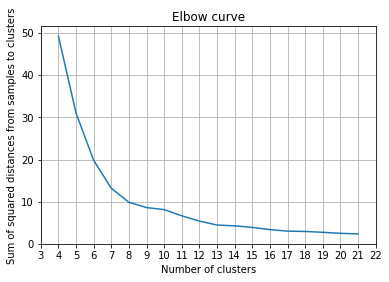

In [12]:
plt.plot(range(4,22), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.ylabel('Sum of squared distances from samples to clusters')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(3, 23, step=1))
plt.show()

##### Select k=8

### PCA

In [13]:
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

def purity_score(y_true, y_pred):
    y_voted_labels = np.zeros(y_true.shape)
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    labels = np.unique(y_true)
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)
    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner
    return accuracy_score(y_true, y_voted_labels), y_voted_labels

def kmeans_purity(X, k, method):
    estimator = KMeans(n_clusters=k, init=method, n_init=10, random_state=0).fit(X)
    accuracy = purity_score(y, estimator.labels_)
    print('accuracy =', accuracy[0])
    pd.DataFrame(estimator.labels_).to_pickle('y_pred_purity.pkl')

In [14]:
def pca_2D_visualization(x, y, title=''):
    pca = PCA(n_components = x.shape[1]).fit_transform(x)
    df = pd.DataFrame(data = pca[:,:2])
    df['label'] = np.array(y)
    plt.axis('equal')
    plt.scatter(df[0][df['label']==0], df[1][df['label']==0], c='g', edgecolor='k', alpha=0.6)
    plt.scatter(df[0][df['label']==1], df[1][df['label']==1], c='r', edgecolor='k', alpha=0.6)
    plt.scatter(df[0][df['label']==2], df[1][df['label']==2], c='y', edgecolor='k', alpha=0.6)
    plt.scatter(df[0][df['label']==3], df[1][df['label']==3], c='b', edgecolor='k', alpha=0.6)
    plt.xlabel('first component')
    plt.ylabel('second component')
    plt.title(title)
    plt.show()

In [15]:
from mpl_toolkits.mplot3d import Axes3D
def pca_3D_visualization(x, y, title=''):
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    pca = PCA(n_components = X_norm1.shape[1]).fit_transform(X_norm1)
    df = pd.DataFrame(data = pca[:,:3])
    ax.scatter(df[0], df[1], df[2], c=y, 
               cmap=plt.cm.Set1, edgecolor='k', s=40)#s is the number of pixels, size of the points
    ax.set_title("First three PCA directions"+title) # X is 1st component, Y is 2nd, Z is 3rd
    ax.set_xlabel("1st eigenvector")
    ax.set_ylabel("2nd eigenvector")
    ax.set_zlabel("3rd eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    plt.show()

In [16]:
kmeans_purity(X_norm1, 8,'k-means++')
y_pred = pd.read_pickle('y_pred_purity.pkl')

accuracy = 0.7869120654396728


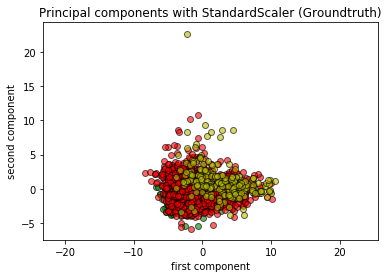

In [17]:
pca_2D_visualization(X_norm1, y, title='Principal components with StandardScaler (Groundtruth)')

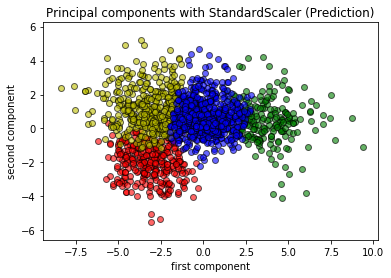

In [18]:
pca_2D_visualization(X_norm1, y_pred, title='Principal components with StandardScaler (Prediction)')

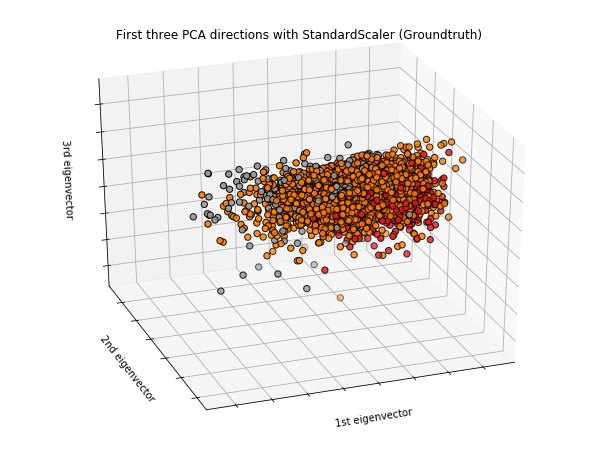

In [19]:
pca_3D_visualization(X_norm1, y, title=' with StandardScaler (Groundtruth)')

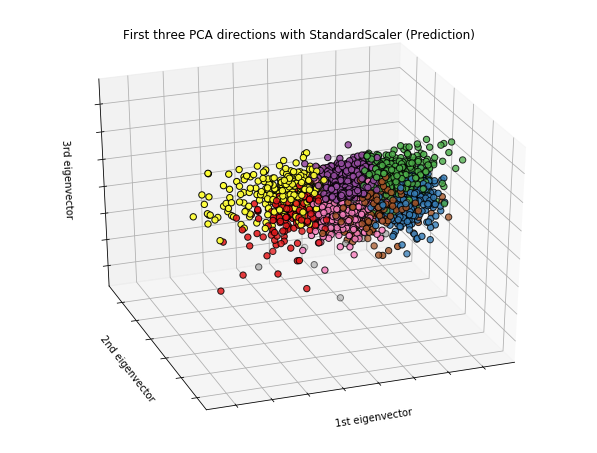

In [20]:
pca_3D_visualization(X_norm1, pd.Series(y_pred[0]), title=' with StandardScaler (Prediction)')

In [21]:
kmeans_purity(X_norm2, 8, 'k-means++')
y_pred = pd.read_pickle('y_pred_purity.pkl')

accuracy = 0.7869120654396728


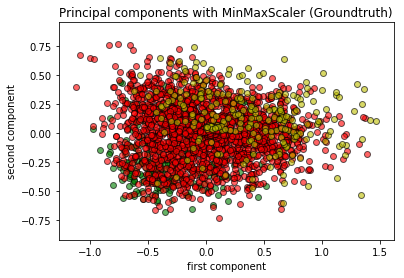

In [22]:
pca_2D_visualization(X_norm2, y, title='Principal components with MinMaxScaler (Groundtruth)')

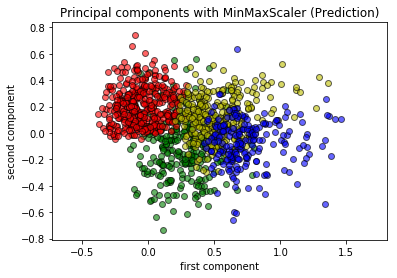

In [23]:
pca_2D_visualization(X_norm2, y_pred, title='Principal components with MinMaxScaler (Prediction)')

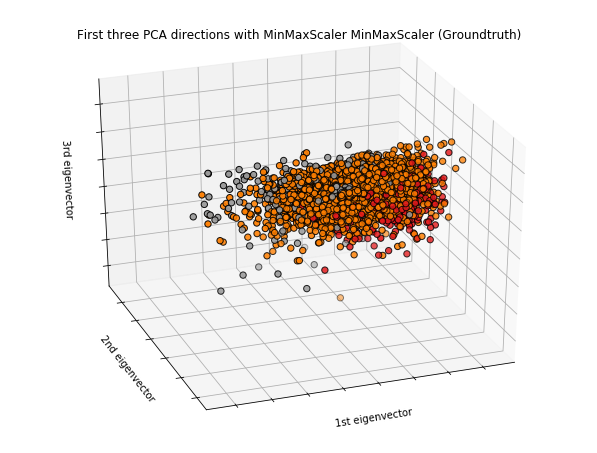

In [24]:
pca_3D_visualization(X_norm2, y, title=' with MinMaxScaler MinMaxScaler (Groundtruth)')

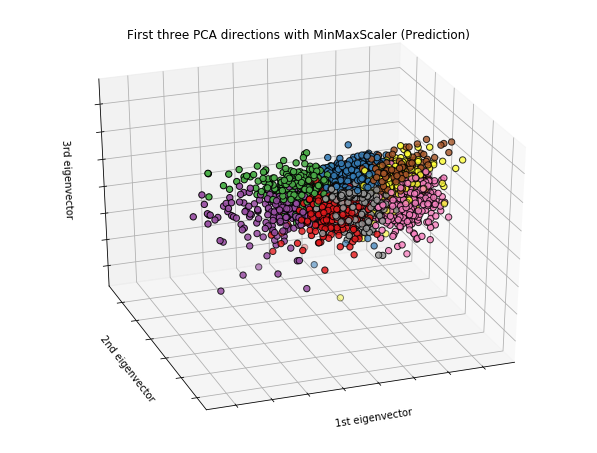

In [25]:
pca_3D_visualization(X_norm2, pd.Series(y_pred[0]), title=' with MinMaxScaler (Prediction)')

In [26]:
kmeans_purity(X_norm3, 8, 'k-means++')
y_pred = pd.read_pickle('y_pred_purity.pkl')

accuracy = 0.7869120654396728


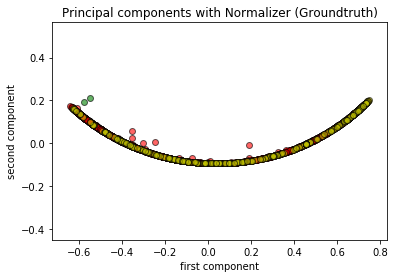

In [27]:
pca_2D_visualization(X_norm3, y, title='Principal components with Normalizer (Groundtruth)')

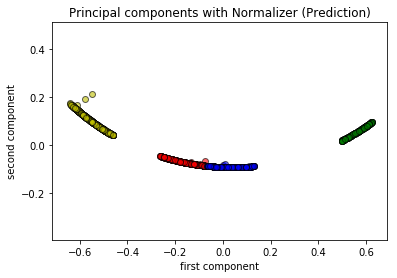

In [28]:
pca_2D_visualization(X_norm3, y_pred, title='Principal components with Normalizer (Prediction)')

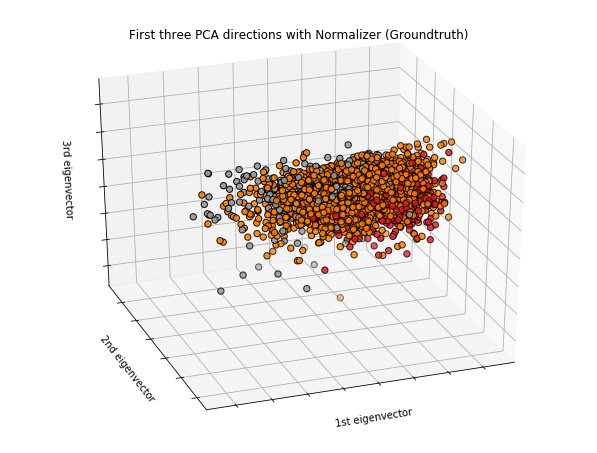

In [29]:
pca_3D_visualization(X_norm3, y, title=' with Normalizer (Groundtruth)')

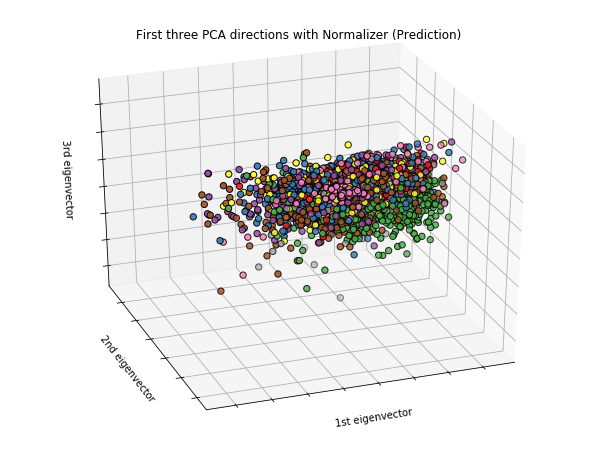

In [30]:
pca_3D_visualization(X_norm3, pd.Series(y_pred[0]), title=' with Normalizer (Prediction)')

### 5 fold cross-validation and gridsearch for best parameters (PCA+Kmeans)

In [31]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import silhouette_score

folds=5
k_fold = KFold(n_splits=folds, shuffle=True, random_state=0)

bin_params = {
    "n_init": range(10,100),
    "max_iter": [100, 200, 300, 400, 500],
    "tol": [.0000001, .000001, .00001, .0001],
}

bin_k_means = KMeans(n_clusters=4)  # set 2 clusters

binary_ensemble = GridSearchCV(
    estimator=bin_k_means,
    param_grid=bin_params,
    cv=k_fold,
)

def para_tune(X):
    binary_ensemble.fit(X)  # fit model to data and return best model
    # Generate labels for data with model with raw data, compute score
    bin_labels = binary_ensemble.predict(X)
    bin_score1 = purity_score(y, bin_labels)[0]
    bin_score2 = silhouette_score(X, bin_labels)
    print('accuracy =', bin_score1)
    print('silhouette_score = ', bin_score2)
    print(binary_ensemble.best_params_)

# tune parameters for three normalizers
para_tune(X_norm1)
para_tune(X_norm2)
para_tune(X_norm3)

accuracy = 0.7869120654396728
silhouette_score =  0.09653563828387877
{'max_iter': 100, 'n_init': 10, 'tol': 1e-07}
accuracy = 0.7869120654396728
silhouette_score =  0.11092807529200538
{'max_iter': 500, 'n_init': 98, 'tol': 1e-05}
accuracy = 0.7869120654396728
silhouette_score =  0.5559567965040961
{'max_iter': 100, 'n_init': 18, 'tol': 1e-05}


# feature selection for classfication model

### Use Normailzer due to its positivity (non-zero mean)

In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [33]:
data_tmp = data.drop(['Readmission Rate (outcome)'],axis=1)
data_norm = pd.DataFrame(scaler3.fit_transform(data_tmp), columns=data_tmp.columns)

In [34]:
data_norm['label'] = y.values

In [35]:
X, Y = data_norm.drop(['label'], axis=1), y
selectkbest = SelectKBest(chi2, k=10).fit(X, Y)

In [36]:
selectkbest.pvalues_

array([9.98811594e-01, 9.91015408e-01, 9.97144129e-01, 9.99624332e-01,
       9.99741723e-01, 9.97704669e-01, 9.99670858e-01, 9.94775288e-01,
       9.98166084e-01, 9.94389991e-01, 9.97471267e-01, 9.99570571e-01,
       5.04863695e-06, 9.98099664e-01, 9.95645457e-01, 6.61376353e-10,
       9.99023831e-01, 9.96529140e-01, 9.98083893e-01, 9.90323180e-01,
       9.95310159e-01, 9.85927937e-01, 9.85709040e-01, 9.98839345e-01,
       9.95672157e-01, 9.94293393e-01, 9.89953055e-01, 9.98891126e-01,
       9.91717993e-01, 9.88924950e-01, 9.71379450e-01, 9.94643619e-01])

In [37]:
selected_array = SelectKBest(chi2, k=10).fit_transform(X, Y)

In [38]:
def get_selected_columns():
    selected_columns = []
    for i in selected_array.T:
        for k in pd.DataFrame(X).columns:
            if i[0] == np.array(X[k])[0]:
                selected_columns.append(k)
    return selected_columns

In [39]:
selected_columns = get_selected_columns()

In [40]:
selected_columns

['Teen Births per 1,000',
 'Median Household Income',
 'Population Size',
 'Injury Deaths',
 'Premature Deaths',
 'Percent White',
 'Average Age',
 'Percent Strongly Agree Understood Care',
 'Percent of Doctors That Always Communicate',
 'Preventable Hospital Stays Rate']

# modelling

### DT, SVM, LR

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [42]:
decisiontreeclassifier = DecisionTreeClassifier(random_state=10)
svc = SVC(random_state=0)
logisticregression = LogisticRegression(multi_class='multinomial',solver='lbfgs', random_state=0)

In [43]:
# Five fold cross validation
for i in [decisiontreeclassifier, svc, logisticregression]:
    print('the accuracy of {}:'.format(i), '\n', cross_val_score(i, X[selected_columns], Y, cv=5).mean())
    print('--------------')

the accuracy of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'): 
 0.6871538454140198
--------------
the accuracy of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False): 
 0.7869156620132822
--------------
the accuracy of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False): 
 0.7869156620132822
--------------


In [44]:
decisiontreeclassifier_2 = DecisionTreeClassifier(random_state=1)
svc_2 = SVC(random_state=1)
logisticregression_2 = LogisticRegression(multi_class='multinomial',solver='lbfgs', random_state=1)
for i in [decisiontreeclassifier_2, svc_2, logisticregression_2]:
    print('the accuracy of {}:'.format(i), '\n', cross_val_score(i, X, Y, cv=5).mean())
    print('--------------')

the accuracy of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'): 
 0.6912480189167262
--------------
the accuracy of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False): 
 0.7869156620132822
--------------
the accuracy of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False): 
 0.7869156620132822
--------------


In [45]:
# pca n_components=2
pca_2=PCA(n_components=2)
pca_data_2=pca_2.fit_transform(data_tmp)
decisiontreeclassifier_3 = DecisionTreeClassifier(random_state=2)
svc_3 = SVC(random_state=2)
logisticregression_3 = LogisticRegression(multi_class='multinomial',solver='lbfgs', random_state=2)
for i in [decisiontreeclassifier_3, svc_3, logisticregression_3]:
    print('the accuracy of {}:'.format(i), '\n', cross_val_score(i, pca_data_2, Y, cv=5).mean())
    print('--------------')

the accuracy of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best'): 
 0.6805998345748236
--------------
the accuracy of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=2, shrinking=True,
  tol=0.001, verbose=False): 
 0.7869156620132822
--------------
the accuracy of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=2, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False): 
 0.2519334720120249
--------------


In [46]:
# use original dataset
decisiontreeclassifier_4 = DecisionTreeClassifier(random_state=3)
svc_4 = SVC(random_state=3)
logisticregression_4 = LogisticRegression(multi_class='multinomial',solver='lbfgs', random_state=3)
for i in [decisiontreeclassifier_4, svc_4, logisticregression_4]:
    print('the accuracy of {}:'.format(i), '\n', cross_val_score(i, data_tmp, Y, cv=5).mean())
    print('--------------')

the accuracy of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'): 
 1.0
--------------
the accuracy of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=3, shrinking=True,
  tol=0.001, verbose=False): 
 0.7869156620132822
--------------
the accuracy of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=3, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False): 
 0.7885709339446553
--------------


In [47]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Five fold cross validation for selected features

In [48]:
# 5折交叉验证，selected_columns 
X_train, X_test, y_train, y_test = train_test_split(X[selected_columns], Y, test_size=.2, random_state=0)
for i in [decisiontreeclassifier, svc, logisticregression]:
    i.fit(X_train, y_train)
    print(classification_report(y_test, i.predict(X_test)))

             precision    recall  f1-score   support

          0       0.48      0.37      0.42        67
          1       0.80      0.82      0.81       370
          2       0.31      0.35      0.33        52

avg / total       0.71      0.71      0.71       489

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        67
          1       0.76      1.00      0.86       370
          2       0.00      0.00      0.00        52

avg / total       0.57      0.76      0.65       489

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        67
          1       0.76      1.00      0.86       370
          2       0.00      0.00      0.00        52

avg / total       0.57      0.76      0.65       489



In [49]:
# Normalize all features
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=0)
for i in [decisiontreeclassifier_2, svc_2, logisticregression_2]:
    i.fit(X_train, y_train)
    print(classification_report(y_test, i.predict(X_test)))

             precision    recall  f1-score   support

          0       0.35      0.33      0.34        67
          1       0.79      0.81      0.80       370
          2       0.37      0.35      0.36        52

avg / total       0.69      0.70      0.69       489

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        67
          1       0.76      1.00      0.86       370
          2       0.00      0.00      0.00        52

avg / total       0.57      0.76      0.65       489

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        67
          1       0.76      1.00      0.86       370
          2       0.00      0.00      0.00        52

avg / total       0.57      0.76      0.65       489



In [50]:
# pca n_components=2
X_train, X_test, y_train, y_test = train_test_split(pca_data_2, Y, test_size=.2, random_state=0)
for i in [decisiontreeclassifier_3, svc_3, logisticregression_3]:
    i.fit(X_train, y_train)
    print(classification_report(y_test, i.predict(X_test)))

             precision    recall  f1-score   support

          0       0.26      0.24      0.25        67
          1       0.78      0.79      0.78       370
          2       0.22      0.21      0.22        52

avg / total       0.65      0.65      0.65       489

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        67
          1       0.76      1.00      0.86       370
          2       0.00      0.00      0.00        52

avg / total       0.57      0.75      0.65       489

             precision    recall  f1-score   support

          0       0.25      0.79      0.38        67
          1       0.88      0.10      0.18       370
          2       0.18      0.79      0.29        52

avg / total       0.72      0.27      0.21       489



In [51]:
# Original dataset
X_train, X_test, y_train, y_test = train_test_split(data_tmp, Y, test_size=.2, random_state=0)
for i in [decisiontreeclassifier_4, svc_4, logisticregression_4]:
    i.fit(X_train, y_train)
    print(classification_report(y_test, i.predict(X_test)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        67
          1       1.00      1.00      1.00       370
          2       1.00      1.00      1.00        52

avg / total       1.00      1.00      1.00       489

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        67
          1       0.76      1.00      0.86       370
          2       0.00      0.00      0.00        52

avg / total       0.57      0.76      0.65       489

             precision    recall  f1-score   support

          0       0.83      0.07      0.14        67
          1       0.77      1.00      0.87       370
          2       1.00      0.02      0.04        52

avg / total       0.80      0.77      0.68       489

